In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import lon180, salmask, latweights, makedz

In [2]:
datafolder = ''

In [3]:
experiment = 'E280' 
model = 'MIROC4m'
folder = datafolder+'Raw_data/'+model+'/'

In [4]:
if experiment == 'E280':
    dsV = xr.open_dataset(folder+experiment+'/MIROC4m_E280_O100yr_vo.nc',decode_times=False)
    dsS = xr.open_dataset(folder+experiment+'/MIROC4m_E280_O100yr_so.nc',decode_times=False)
    dsrTS = xr.open_dataset(folder+experiment+'/MIROC4m_Exxx_fx_sftlf_ts_atl.nc',decode_times=False)
    dsrUV = xr.open_dataset(folder+experiment+'/MIROC4m_Exxx_fx_sftlf_uv_atl.nc',decode_times=False)
else:
    dsV = xr.open_dataset(folder+experiment+'/MIROC4m_Eoi400_O100yr_vo.nc',decode_times=False)
    dsS = xr.open_dataset(folder+experiment+'/MIROC4m_Eoi400_O100yr_so.nc',decode_times=False)
    dsrTS = xr.open_dataset(folder+experiment+'/MIROC4m_Eoixxx_fx_sftlf_ts_atl.nc',decode_times=False)
    dsrUV = xr.open_dataset(folder+experiment+'/MIROC4m_Eoixxx_fx_sftlf_uv_atl.nc',decode_times=False)

## Separation MOC and gyre FW Atlantic

In [5]:
vvel = dsV.vo[0]*100 #vvel in cm/s
salt = dsS.so[0] #salt in psu

#Atlantic Ocean region
regionv = dsrUV.sftlf[0]
regiont = dsrTS.sftlf[0]

In [6]:
ds = dsS.copy(deep=True)

#1-D array with spacing of depth grid
dz = np.zeros(len(ds.depth))
dz[0] = ds.depth[0].values*2
depth = dz[0]
for i in range(1,len(ds.depth)):
    dz[i] = (ds.depth[i].values-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
ds['dz'] = xr.DataArray(data=dz, dims=("depth"))
dz = ds.dz

#2-D array with spacing of horizontal T grid
r = 6.37122e8 #radius Earth in cm
dlon = np.deg2rad((ds.lon[2]-ds.lon[1]))*r*np.cos(np.deg2rad(ds.lat)) #Lon spacing. Units: cm

a = dlon
dlon = np.zeros([len(ds.lat),len(ds.lon)])
for i in range(len(ds.lon)):
    dlon[:,i]=a.values
ds['dlon']=xr.DataArray(data = dlon, dims=("lat","lon"))
dlon = ds.dlon

In [7]:
#Define reference salinity S0 as average Atlantic salinity
folder2 = datafolder+'Processed/'
dssal = xr.open_dataset(folder2+model+'/'+experiment+'/so_1x1_100yr.nc')
dssal = lon180(dssal)

S0 = dssal.so.where(salmask()>-1).weighted(makedz(dssal)).mean(dim='z').weighted(latweights()).mean()

In [8]:
SALT = salt.where(regiont<0.9)  #  [g/kg]

vvel = vvel.fillna(0).interp(lat = dsS.lat, lon = dsS.lon, method='linear')
VVEL = vvel*SALT/SALT #[cm/s]

In [9]:
#zonal mean components 
VVEL_zm = VVEL.mean(dim='lon')
SALT_zm = SALT.mean(dim='lon')

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components 
SALT_prime = (SALT - SALT_zm) # azonal heat component (x,y,z) [g/kg]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

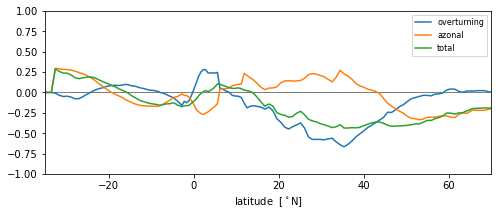

In [10]:
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon*dz).sum(dim=['lon','depth']))/1e12
Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon*dz).sum(dim=['lon','depth']))/1e12 
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon*dz).sum(dim=['lon','depth']))/1e12

plt.figure(figsize=(8,3))
plt.axhline(0,c='k',lw=.5)
plt.plot(dsV.lat, Fov, label='overturning')
plt.plot(dsV.lat, Faz, label='azonal')
plt.plot(dsV.lat, Ftotal, label='total')
#plt.plot(dsV.lat, Fov+Faz, label='ov+az')

plt.xlim([-35,70])
plt.ylim([-1,1])
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)

In [11]:
dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov), Faz=(["lat"], Faz), Ftot=(["lat"], Ftotal)), coords = dict(lat = dsV.lat.values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_100yr.nc')

## FW Labrador

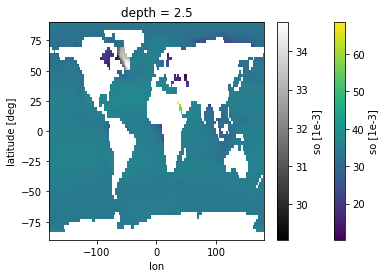

In [13]:
dsS = lon180(dsS)
regiont = lon180(regiont)
salt = lon180(salt)
vvel = lon180(vvel)

ds = dsS.copy(deep=True)

#1-D array with spacing of depth grid
dz = np.zeros(len(ds.depth))
dz[0] = ds.depth[0].values*2
depth = dz[0]
for i in range(1,len(ds.depth)):
    dz[i] = (ds.depth[i].values-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
ds['dz'] = xr.DataArray(data=dz, dims=("depth"))
dz = ds.dz

#2-D array with spacing of horizontal T grid
r = 6.37122e8 #radius Earth in cm
dlon = np.deg2rad((ds.lon[2]-ds.lon[1]))*r*np.cos(np.deg2rad(ds.lat)) #Lon spacing. Units: cm

a = dlon
dlon = np.zeros([len(ds.lat),len(ds.lon)])
for i in range(len(ds.lon)):
    dlon[:,i]=a.values
ds['dlon']=xr.DataArray(data = dlon, dims=("lat","lon"))
dlon = ds.dlon

#check region
salt[0].plot()
salt[0].where(regiont<0.9).where(dsS.lon<-45).where(dsS.lon>-70).where(dsS.lat>=50).where(ds.lat<70).plot(cmap='gray')

In [14]:
SALT = salt.where(regiont<0.9).where(dsS.lon<-45).where(dsS.lon>-70).where(dsS.lat>=50).where(dsS.lat<70)  #  [J/(kg K) * kg/cm^3 * degC] = [J/cm]
VVEL = vvel*SALT/SALT
                                                                                              
VVEL_zm = VVEL.mean(dim='lon')
SALT_zm = SALT.mean(dim='lon')

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components on u grid
SALT_prime = (SALT - SALT_zm) # azonal heat component (x,y,z) 
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) 

Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon*dz).sum(dim=['lon','depth']))/1e12
Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon*dz).sum(dim=['lon','depth']))/1e12 
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon*dz).sum(dim=['lon','depth']))/1e12

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[165:-15]), Faz=(["lat"], Faz[165:-15]), Ftot=(["lat"], Ftotal[165:-15])), coords = dict(lat = dsV.lat[165:-15].values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Lab_100yr.nc')

## FW Fram Strait

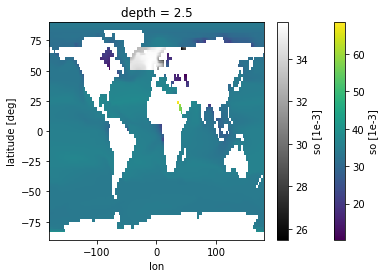

In [15]:
#check region
salt[0].plot()
salt[0].where(regiont<0.9).where(dsS.lon>=-45).where(dsS.lat>=50).where(ds.lat<70).plot(cmap='gray')

In [16]:
SALT = salt.where(regiont<0.9).where(dsS.lon>=-45).where(dsS.lat>=50).where(ds.lat<70) 
VVEL = vvel*SALT/SALT
                                                                                              
VVEL_zm = VVEL.mean(dim='lon')
SALT_zm = SALT.mean(dim='lon')

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components on u grid
SALT_prime = (SALT - SALT_zm) # azonal heat component (x,y,z) 
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) 

Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon*dz).sum(dim=['lon','depth']))/1e12
Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon*dz).sum(dim=['lon','depth']))/1e12 
Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon*dz).sum(dim=['lon','depth']))/1e12

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[165:-15]), Faz=(["lat"], Faz[165:-15]), Ftot=(["lat"], Ftotal[165:-15])), coords = dict(lat = dsV.lat[165:-15].values))    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Fram_100yr.nc')

## FW Bering Strait

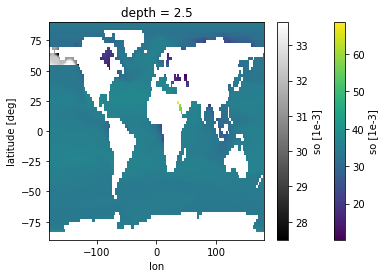

In [17]:
#check region
salt[0].plot()
salt[0].where(regiont==1).where(dsS.lat>=55).where(dsS.lat<70).where(dsS.lon<-100).plot(cmap='gray')

In [18]:
if experiment == 'E280':
    SALT = salt.where(regiont==1).where(dsS.lat>=55).where(dsS.lat<70).where(dsS.lon<-100) 
    VVEL = vvel*SALT/SALT

    VVEL_zm = VVEL.mean(dim='lon')
    SALT_zm = SALT.mean(dim='lon')

    SALT_zm_3D = SALT/SALT
    SALT_zm_3D = SALT_zm_3D*SALT_zm

    VVEL_zm_3D = VVEL/VVEL
    VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

    SALT_prime = (SALT - SALT_zm) 
    VVEL_prime = (VVEL - VVEL_zm)  

    Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*dlon*dz).sum(dim=['lon','depth']))/1e12
    Faz = (-1/S0*(VVEL_prime*SALT_prime*dlon*dz).sum(dim=['lon','depth']))/1e12 
    Ftotal = (-1/S0*(VVEL*(SALT-S0)*dlon*dz).sum(dim=['lon','depth']))/1e12        

    dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[165:-15]), Faz=(["lat"], Faz[165:-15]), Ftot=(["lat"], Ftotal[165:-15])), coords = dict(lat = dsV.lat[165:-15].values))    
    xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_BS_100yr.nc')